# Librerie

In [1]:
# installo le librerie
!pip install pydicom
!pip install pandas>=1.2.0
!pip install xlrd>=1.2.0.
!pip install --upgrade xlrd
!pip install sklearn

zsh:1: 1.2.0 not found
zsh:1: 1.2.0. not found


In [3]:
# importo le librerie
import sys  # system for info
import pandas as pd # pandas
import numpy as np  # numpy
from PIL import Image

#from sklearn.model_selection import train_test_split    # split db in train and validation
import os   # os for paths and dirs

from tqdm import tqdm   #tqdm for loading bars

import gc   # garbage collector for memory management if needed
import copy # copy of dbs
import cv2  # opencv
import pydicom  # pydicom library for dicom file import


import tensorflow as tf # tensorflow
from tensorflow import keras    # keras
from pathlib import Path    #path library for paths management

ModuleNotFoundError: No module named 'cv2'

In [6]:
# import dei layer per la creazione del modello
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, AveragePooling2D, BatchNormalization, GlobalAveragePooling2D

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
# funzioni per stampare il grafico del modello
from tensorflow.keras.utils import plot_model, to_categorical   
import plotly.graph_objects as go
from plotly.offline import plot as plotly_plot
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, accuracy_score, log_loss, confusion_matrix, hinge_loss

# UTILS

## UTILS PATHS

In [ ]:
# crea i path necessari
checkpointPath = Path('Classification/OUTPUTS/CHECKPOINTS')    #checkpoint per l'accuracy
graphPath = Path('Classification/OUTPUTS/GRAPHS/')  #graphs plots
pathSavedModel = Path('Classification/OUTPUTS/MODELS-PB/')  #model saved
plotpath = Path('Classification/OUTPUTS/PLTS/') #plots of history
txtOutEvalpath = Path('Classification/OUTPUTS/EVALUATIONS/') #plots of history


databasePath = Path('drive/MyDrive/Dataset/TrainSet (1)/')    # path of the xls with the Y
databasePathIMAGES = Path('drive/MyDrive/Dataset/TrainSet (1)/TrainSet/') # path of the images png

In [ ]:
# controlla se i path esistono, altrimenti li crea
checkpointPath.mkdir(parents=True, exist_ok=True)
graphPath.mkdir(parents=True, exist_ok=True)
pathSavedModel.mkdir(parents=True, exist_ok=True)
plotpath.mkdir(parents=True, exist_ok=True)
txtOutEvalpath.mkdir(parents=True, exist_ok=True)

## RANDOM NUMBER

In [ ]:
random_seed = 42    #random seed per poter riprodurre l'esperimento

## GLOBAL VARIABLES

In [ ]:
IMAGE_SIZE = 224  #dimensione delle immagini in input (224x224)
CLASS_NAMES = ['MILD', 'SEVERE']    #valori delle label T

# FUNCTIONS

### Loader Dicom from Winner Hackathon

In [ ]:
def clahe_transform(img):
    clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(4, 4))
    img = clahe.apply((img * 255).astype(np.uint8)) / 255
    return img

def midpoint(x1, y1, x2, y2):
    x_mid = int((x1 + x2)/2)
    y_mid = int((y1 + y2)/2)
    return (x_mid, y_mid)

def normalize(img, min_val=None, max_val=None):
    if not min_val:
        min_val = img.min()
    if not max_val:
        max_val = img.max()
    img = (img - min_val) / (max_val - min_val)
    return img

def load_img(img_path):
    filename, extension = os.path.splitext(img_path)
    if extension == ".dcm":
        dicom = pydicom.dcmread(img_path)
        img = dicom.pixel_array.astype(float)
        photometric_interpretation = dicom.PhotometricInterpretation
    else:
        img = Image.open(img_path)
        img = np.array(img).astype(float)
        photometric_interpretation = 'MONOCHROME1'
    return img, photometric_interpretation


# def loader(img_path, img_dim, mask_path=None, box=None, clahe=False):
def loader(img_path, img_dim, clahe=False):
    # Img
    img, photometric_interpretation = load_img(img_path)
    min_val, max_val = img.min(), img.max()

    # Pathometric Interpretation
    if photometric_interpretation == 'MONOCHROME1':
        img = np.interp(img, (min_val, max_val), (max_val, min_val))
    # To Grayscale
    # if img.ndim > 2:
        # img = img.mean(axis=2)

    # Resize
    img = cv2.resize(img, (img_dim, img_dim))
    # Normalize
    img = normalize(img, min_val=min_val, max_val=max_val)
    # CLAHE
    if clahe:
        img = clahe_transform(img)
    
    # To 3 Channels
    img = np.stack((img, img, img), axis=-1)
    
    return img

def loadAllImgToArray(DB,dimention,cName,basePt):
    paths = DB[cName].to_list()

    # print(paths)
    imgs = []
    for p in tqdm(paths):
        img = loader(basePt / p , dimention, clahe= True)
        imgs.append(img)

    imgs = np.array(imgs)
    return imgs
    

# Load From DB

### Import Database DICOM

In [ ]:
# monto il drive dal quale prendere le immagini
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# leggo tutto il dataset
COVID19_dataHK = pd.read_excel(databasePath/Path('trainClinData.xls'))

# prendo solo la label di output e il path della relativa immagine
COVID19_dataHK = pd.DataFrame(COVID19_dataHK[['ImageFile','Prognosis']])

In [ ]:
# struttura
COVID19_dataHK.head()

,ImageFile,Prognosis
0,P_102.png,SEVERE
1,P_131.png,MILD
2,P_132.png,MILD
3,P_117.png,MILD
4,P_16.png,SEVERE


In [ ]:
# transcodifica di label di output con valori 0 e 1
mapping = {}
for x in range(len(CLASS_NAMES)):
    mapping[CLASS_NAMES[x]] = x

takename = copy.deepcopy(COVID19_dataHK['Prognosis'])
for x in range(len(takename)):
    takename[x] = mapping[takename[x]]


one_h_enc = to_categorical(takename)

COVID19_dataHK['MILD'] = one_h_enc[:,0]
COVID19_dataHK['SEVERE'] = one_h_enc[:,1]

In [ ]:
# struttura
COVID19_dataHK.head()

,ImageFile,Prognosis,MILD,SEVERE
0,P_102.png,SEVERE,0.0,1.0
1,P_131.png,MILD,1.0,0.0
2,P_132.png,MILD,1.0,0.0
3,P_117.png,MILD,1.0,0.0
4,P_16.png,SEVERE,0.0,1.0


In [ ]:
# salvo nomi immagini
X_full = pd.DataFrame(COVID19_dataHK[['ImageFile']])
# salvo relative label di output
Y_full = pd.DataFrame(COVID19_dataHK[['MILD','SEVERE']])

In [ ]:
# split del train e test per il train del modello, mantenedo la corrispondenza fra immagine e label di output

X_train, X_val, Y_train, Y_val = train_test_split(X_full,Y_full, test_size=0.2,shuffle=True, random_state=random_seed)

print("Training set shape X : "+str(X_train.shape)+"   y : "+str(Y_train.shape))
print("Validation set shape X : "+str(X_val.shape)+"   y : "+str(Y_val.shape))

Training set shape X : (882, 1)   y : (882, 2)
Validation set shape X : (221, 1)   y : (221, 2)


### IMPORT PNG instead of DICOM

In [ ]:
# carico le immagini dal database
X_trainIMG = loadAllImgToArray(X_train,IMAGE_SIZE,'ImageFile',databasePathIMAGES)
X_valIMG = loadAllImgToArray(X_val,IMAGE_SIZE,'ImageFile',databasePathIMAGES)

100%|██████████| 221/221 [03:16<00:00,  1.13it/s]


In [ ]:
# mostra la shape delle imagini

print(X_trainIMG.shape)
print(X_valIMG.shape)

(882, 224, 224, 3)
(221, 224, 224, 3)


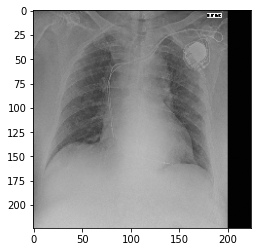

In [ ]:
# mostra un immagine
plt.figure()
plt.imshow(X_valIMG[30])

# Model load and classification

## Resnet50

In [ ]:
#   MODEL CREATION
 
#  creo il modello base pre trainato
base_model = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(IMAGE_SIZE,IMAGE_SIZE,3),
    pooling=None,
    )

# aggiungo un layer average pooling
x = base_model.output
x = GlobalAveragePooling2D()(x)
# aggiungo un fully-connected layer
x = Dense(1024, activation='relu')(x)
# aggiungo un logistic layer
output = Dense(2, activation='softmax')(x)

# modello totale
model = Model(inputs=base_model.input, outputs=output)

In [ ]:
# stampo il grafico modello

plot_model(model, to_file=plotpath / Path('ResNet50Model.png'), show_shapes=True, show_layer_names=True)

In [ ]:
# MODEL COMPILE: imposto le variabili di train del modello

initial_learning_rate = 1e-3    # learning rate iniziali
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(       #learning rate schedule with exponential decay
    initial_learning_rate, decay_steps=500, decay_rate=0.9, staircase=False
)

model.compile(
        #optimizer=tf.keras.optimizers.Adam(),   #optimizer Adam standard
         optimizer=tf.keras.optimizers.Adam(lr_schedule),  #with learning rate schedule (before)
        # optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-2, decay=1e-10),    #with decay
        # optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-3),     #start from 1e-3

        # loss="binary_crossentropy",       #loss binary crossentropy
        loss="categorical_crossentropy",    #loss categorical crossentropy (at least two classes)
        # loss="hinge",                     #loss hinge

        # metrics=['accuracy', 'precision', 'recall'],          #metric with precision and recall
        metrics=['accuracy'],   #metric with accuracy only
)

In [ ]:
# MODEL TRAIN

# CREATE CALLBACKS
# checkpoint that saves the model at path checkpointPath/ResNet50_model when the val_accuracy increase
checkpoint_accuracy = tf.keras.callbacks.ModelCheckpoint(
						checkpointPath / Path('ResNet50_model'), 
						monitor='val_accuracy', verbose=1, 
						save_best_only=True, mode='max')

# callback for early stopping that monitor loss with patience of 5
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50, verbose=0)

#list of callbacks
callbacks_list = [checkpoint_accuracy, early_stopping]

#fit
history = model.fit(
        x = X_trainIMG,     #x_train
        y = Y_train,        #y_train
        epochs = 500,        #epochs
        validation_data = [X_valIMG,Y_val],     #validation data
        callbacks = callbacks_list,    #callback list
        batch_size=16   #batch size
)

In [ ]:
# stampo i grafici relativi al train del modello

# LOSSES
plt.clf()
fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['loss'],
                    name='Train loss'))
fig.add_trace(go.Scatter(
                    y=history.history['val_loss'],
                    name='Validation loss'))
fig.update_layout(height=500, 
                  width=700,
                  title='Loss CNN',
                  xaxis_title='Epoch',
                  yaxis_title='Loss')
fig.show()
plotly_plot(fig, filename=str(Path(graphPath / Path("ResNet50_loss.html"))), auto_open=False)

# ACCURACY
fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['accuracy'],
                    name='Train accuracy'))
fig.add_trace(go.Scatter(
                    y=history.history['val_accuracy'],
                    name='Validation accuracy'))

fig.update_layout(height=500, 
                  width=700,
                  title='Accuracy/Precision/Recall CNN',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy')
fig.show()
plotly_plot(fig, filename=str(Path(graphPath / Path("ResNet50_accuracy.html"))), auto_open=False)

'Classification/OUTPUTS/GRAPHS/ResNet50_accuracy.html'

<Figure size 432x288 with 0 Axes>

In [ ]:
# calcolo delle metriche di valutazione del modello e fornisco i risultati

bestPt = checkpointPath / Path('ResNet50_model')
model = tf.keras.models.load_model(bestPt)


evaluation = model.evaluate(x = X_valIMG, y = Y_val)
prediction = model.predict(X_valIMG)

ypreds = np.argmax(prediction, axis=1)
yground = np.argmax(Y_val.to_numpy(), axis=1)

score = accuracy_score(yground, ypreds)
print('accuracy: ', score)

loss = log_loss(yground, ypreds)
print('log_loss: ', loss)

Hloss = hinge_loss(yground, ypreds)
print('hinge_loss: ', Hloss)

precision = precision_score(yground, ypreds)
print('precision: ', precision)

recall = recall_score(yground, ypreds)
print('recall: ', recall)

cmatrix = confusion_matrix(yground, ypreds)
print(cmatrix)





evaluation = dict(zip(model.metrics_names,evaluation))
print(evaluation)
with open(txtOutEvalpath / Path('ResNet50_model.txt'), 'w') as f:
    f.write('CNN'+'\n\n')
    for k, v in evaluation.items():
        f.write(str(k) + ' >>> '+ str(v) + '\n\n')
    f.write('CNN'+'\n\n')
    f.write('SKLEARN METRICS:')
    f.write(str('Loss') + ' >>> '+ str(loss) + '\n\n')
    f.write(str('Hinge Loss') + ' >>> '+ str(Hloss) + '\n\n')
    f.write(str('Accuracy') + ' >>> '+ str(score) + '\n\n')
    f.write(str('Precision') + ' >>> '+ str(precision) + '\n\n')
    f.write(str('Recall') + ' >>> '+ str(recall) + '\n\n')
    f.write(str('Confusion Matrix') + ' >>> '+ str(cmatrix) + '\n\n')

In [ ]:
# Salva il modello in formato *.h5
model.save("Classification/OUTPUTS/modello.h5")